# **Prepare Kaggle Enviroment**

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faridakhaledaly","key":"0ff9c567c66f6538c82d86465cf0b231"}'}

In [2]:
# Install Kaggle API
!pip install -q kaggle

In [3]:
# Create a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Verify the Kaggle API setup
!kaggle datasets list

ref                                                         title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance        Student Habits vs Academic Performance                19512  2025-04-12 10:49:08.663000          15093        272  1.0              
khushikyad001/screen-time-and-app-usage-dataset-iosandroid  Screen Time and App Usage Dataset (iOS/Android)      157038  2025-04-19 13:23:41.067000           1476         25  1.0              
fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid     Heart Attack Dataset                                  16250  2025-04-30 21:58:22.740000           2212         38  1.0              
khushikyad001/impact-of-screen-time

# **Load and Unzip (Face Mask Detection) Dataset** 😷

In [5]:
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip -q face-mask-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown


# **Import necessary libraries**

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Our used parameters**

In [7]:
IMG_SIZE = 128
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

# **Visualize dataset samples from both classes**

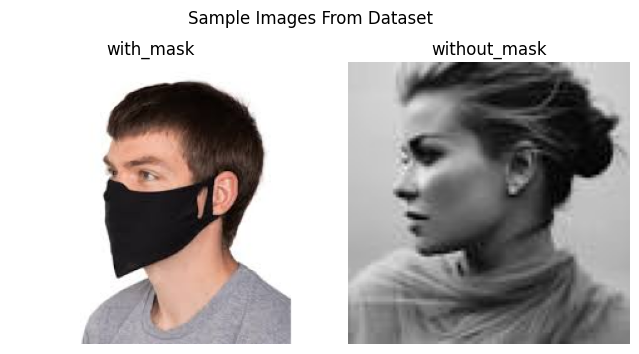

In [8]:
dataset_path = "/content/data"
categories = ["with_mask", "without_mask"]

plt.figure(figsize=(8, 4))
for idx, category in enumerate(categories):
    folder = os.path.join(dataset_path, category)
    image_path = os.path.join(folder, os.listdir(folder)[4])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, idx + 1)
    plt.imshow(image)
    plt.title(category)
    plt.axis("off")
plt.suptitle("Sample Images From Dataset")
plt.show()

# **Image counts per class**

with_mask: 3725 images
without_mask: 3828 images


<ipython-input-9-5ebf00ffdeba>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=["#ff69b4", "#ffb6c1"])


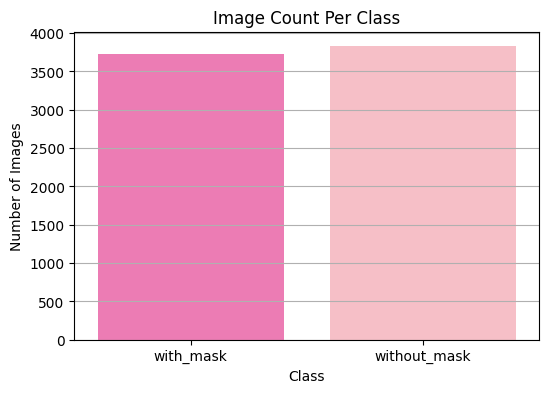

In [9]:
counts = {c: len(os.listdir(os.path.join(dataset_path, c))) for c in categories}

for category, count in counts.items():
    print(f"{category}: {count} images")

plt.figure(figsize=(6, 4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=["#ff69b4", "#ffb6c1"])
plt.title("Image Count Per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.grid(True, axis='y')
plt.show()

# **2.Preprocessing and segmentation step**

In [44]:
from sklearn.cluster import KMeans
import cv2
import numpy as np

IMG_SIZE = 128

def preprocess_image(img_path):
    # Load image
    img = cv2.imread(img_path)

    # 1. Resize image for consistency
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Required for model input

    # 2. Convert to grayscale (Color space conversion) to simplify processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Apply histogram equalization (Contrast Adjustment)
    eq = cv2.equalizeHist(gray)  # Improves local contrast and highlights features

    # 4. Apply Gaussian Blur (Noise Reduction + Softening)
    blur = cv2.GaussianBlur(eq, (5, 5), 0)  # Smoothens image, reduces detail noise

    # 5. Sharpen image (Light sharpening filter)
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])  # Simple sharpening kernel
    sharpened = cv2.filter2D(blur, -1, kernel_sharp)

    # 6. Morphological operation (Closing) to remove small holes inside foreground
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # morph = cv2.morphologyEx(sharpened, cv2.MORPH_CLOSE, kernel)

    # 7. Segmentation (K-Means) – unchanged per your request
    reshaped = sharpened.reshape((-1, 1))
    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(reshaped)
    clustered = kmeans.labels_.reshape((IMG_SIZE, IMG_SIZE)).astype("uint8") * 255

    # 8. Normalize image (Scaling)
    final = sharpened.astype("float32") / 255.0  # Normalize pixel range to [0, 1]

    # Return preprocessed image + KMeans mask
    return np.expand_dims(final, axis=-1), clustered

# **Visualize a sample**

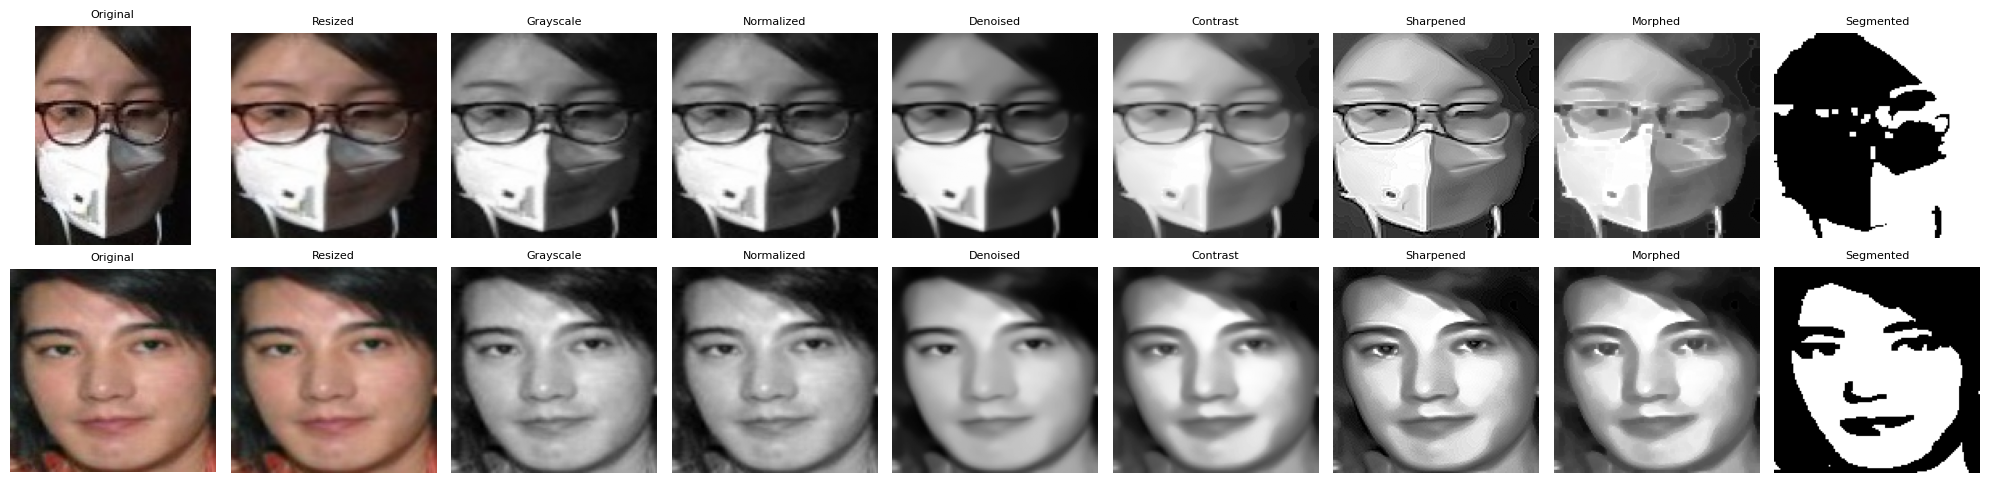

In [41]:
from sklearn.cluster import KMeans
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128

def collect_preprocessing_steps(img_path):
    steps = []
    titles = []

    img = cv2.imread(img_path)
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    steps.append(original)
    titles.append("Original")

    resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    steps.append(resized[..., ::-1])
    titles.append("Resized")

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    steps.append(gray)
    titles.append("Grayscale")

    normalized = gray.astype("float32") / 255.0
    steps.append((normalized * 255).astype("uint8"))
    titles.append("Normalized")

    denoised = cv2.fastNlMeansDenoising((normalized * 255).astype("uint8"), h=10)
    steps.append(denoised)
    titles.append("Denoised")

    contrast = cv2.equalizeHist(denoised)
    steps.append(contrast)
    titles.append("Contrast")

    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(contrast, -1, kernel_sharp)
    steps.append(sharpened)
    titles.append("Sharpened")

    morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morphed = cv2.morphologyEx(sharpened, cv2.MORPH_CLOSE, morph_kernel)
    steps.append(morphed)
    titles.append("Morphed")

    reshaped = morphed.reshape((-1, 1))
    kmeans = KMeans(n_clusters=2, n_init=10)
    kmeans.fit(reshaped)
    clustered = kmeans.labels_.reshape((IMG_SIZE, IMG_SIZE)).astype("uint8") * 255
    steps.append(clustered)
    titles.append("Segmented")

    return steps, titles

# === Load one image from each class
fig, axes = plt.subplots(2, 9, figsize=(20, 5))

for row, label in enumerate(categories):
    sample_path = os.path.join(dataset_path, label, os.listdir(os.path.join(dataset_path, label))[45])
    steps, titles = collect_preprocessing_steps(sample_path)

    for col in range(len(steps)):
        ax = axes[row, col]
        step_img = steps[col]

        if len(step_img.shape) == 2:
            ax.imshow(step_img, cmap='gray')
        else:
            ax.imshow(step_img)

        ax.set_title(titles[col], fontsize=8)
        ax.axis("off")

# Titles per row
axes[0, 0].set_ylabel("With Mask", fontsize=10)
axes[1, 0].set_ylabel("Without Mask", fontsize=10)

plt.tight_layout()
plt.show()


# **Load and preprocess all data**

In [45]:
data, labels = [], []

# Loop through both classes: with_mask and without_mask
for label in categories:
    folder = os.path.join(dataset_path, label)
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)

        try:
            # Apply preprocessing; segmentation output is discarded for training
            pre, _ = preprocess_image(fpath)
            data.append(pre)
            labels.append(label)

        except Exception as e:
            print(f"Skipped file {fname} due to error: {e}")

# Label encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Convert to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split into train/test
trainX, testX, trainY, testY = train_test_split(
    data, labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)


# **Robust CNN**

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Layer 1: Initial convolution block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))  # Learn 32 filters on 3x3 patches
model.add(BatchNormalization())  # Normalize activations for faster convergence
model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample by 2x2 to reduce spatial size and computation

# Layer 2: Deeper convolution block
model.add(Conv2D(64, (3, 3), activation='relu'))  # Increase feature map count to learn more patterns
model.add(BatchNormalization())  # Normalize again to maintain stable activations
model.add(MaxPooling2D(pool_size=(2, 2)))  # Further reduce spatial dimensions

# Layer 3: Even deeper with regularization
model.add(Conv2D(128, (3, 3), activation='relu'))  # 128 filters for high-level features
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Prevent overfitting by randomly disabling 30% of neurons

# Flatten and Fully Connected
model.add(Flatten())  # Flatten feature maps to 1D vector for dense layers
model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 neurons
model.add(BatchNormalization())
model.add(Dropout(0.4))  # avoid overfitting

# Output Layer: 2-Class softmax
model.add(Dense(2, activation='softmax'))  # Output probabilities for 2 classes (mask / no mask)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Train model with augmentation**

In [47]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

H = model.fit(
    aug.flow(trainX, trainY, batch_size=32),
    validation_data=(testX, testY),
    epochs=30,
    verbose=1
)

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.6900 - loss: 0.6377 - val_accuracy: 0.4977 - val_loss: 1.6063
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7580 - loss: 0.4977 - val_accuracy: 0.7412 - val_loss: 0.5229
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7717 - loss: 0.4720 - val_accuracy: 0.5804 - val_loss: 2.1207
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7931 - loss: 0.4436 - val_accuracy: 0.8312 - val_loss: 0.3829
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7996 - loss: 0.4240 - val_accuracy: 0.8054 - val_loss: 0.4119
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8224 - loss: 0.3957 - val_accuracy: 0.8829 - val_loss: 0.2883
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8211 - loss: 0.3814 - val_accuracy: 0.8736 - val_loss: 0.3031
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.8389 - loss: 0.3491 - 

## **Lets Evaluate (Accuracy, Precision, Recall, F1-score)**

In [50]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

   with_mask       0.93      0.94      0.93       745
without_mask       0.94      0.93      0.94       766

    accuracy                           0.93      1511
   macro avg       0.93      0.93      0.93      1511
weighted avg       0.93      0.93      0.93      1511



# **Plot training history (LOSS and Accuracy curves)**

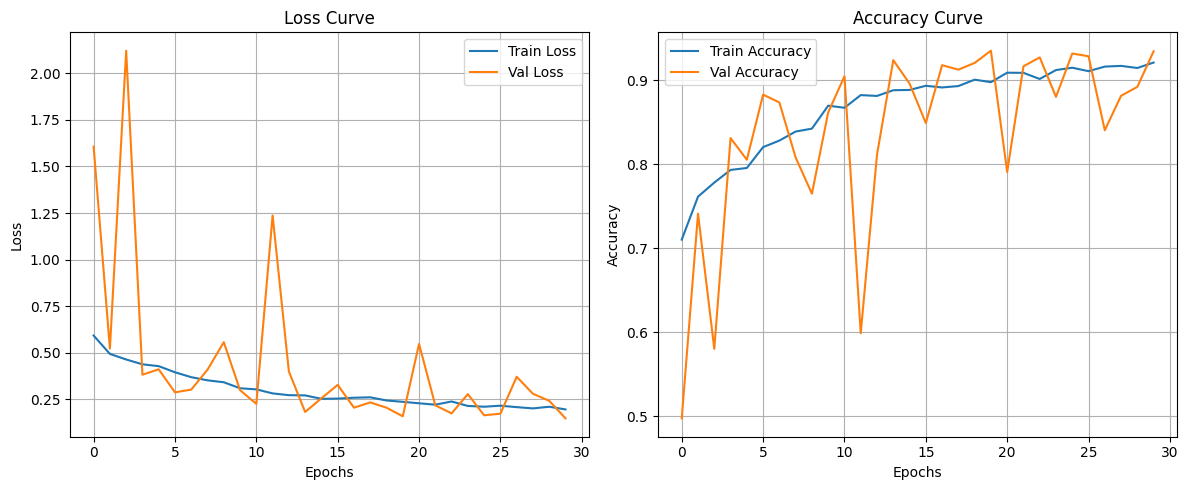

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Train Loss')
plt.plot(H.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Lets Save Our model**

In [52]:
model.save("mask_detector_model.keras")

# **Test on an image has both (With and without mask classes)**

## **Using OpenCV Haar face detector**

Saving images.jpg to images.jpg


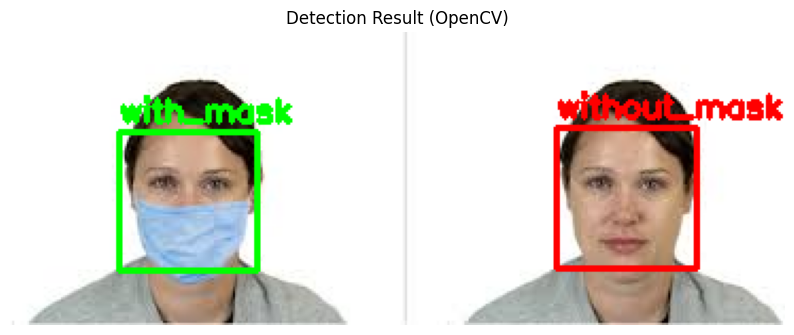

In [55]:
from keras.models import load_model
model = load_model("mask_detector_model.keras")  # Load trained face mask detection model

uploaded = files.upload()  # Upload an image file from local system

# Load OpenCV's built-in face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Process each uploaded image
for img_name in uploaded.keys():
    image = cv2.imread(img_name)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_full = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for face detection

    # Detect faces using Haar cascade
    faces = face_cascade.detectMultiScale(gray_full, scaleFactor=1.1, minNeighbors=4)

    for (x, y, w, h) in faces:
        face_img = image[y:y + h, x:x + w]  # Crop face from image
        try:
            #Apply same preprocessing as training
            resized = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))  # Resize to match model input
            gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)  # Grayscale
            eq = cv2.equalizeHist(gray)  # Contrast enhancement
            denoise = cv2.fastNlMeansDenoising(eq, h=10)  # Noise reduction

            final_img = denoise.astype("float32") / 255.0  # Normalize pixel values
            final_img = np.expand_dims(final_img, axis=-1)  # Add channel dimension
            final_img = np.expand_dims(final_img, axis=0)   # Add batch dimension

            # Run prediction
            pred = model.predict(final_img, verbose=0)
            class_idx = np.argmax(pred)  # Get predicted class index
            label = lb.classes_[class_idx]  # Get class label string

            # Draw result
            color = (0, 255, 0) if label == "with_mask" else (255, 0, 0)  # Green or red box
            cv2.rectangle(img_rgb, (x, y), (x + w, y + h), color, 2)  # Draw bounding box
            cv2.putText(img_rgb, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Label

        except Exception as e:
            print("Error on detected face:", e)

    # Show the final image with bounding boxes and labels
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Detection Result (OpenCV)")
    plt.show()

In [56]:
# Download model for local use
files.download("mask_detector_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>